### Decision Tree Classifier Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.category import UnitData
import math

In [2]:
df = pd.read_csv("monsters.csv")

In [3]:
#adding the saves
def find_save(arg1, arg2):
    #if the save is null (arg2) it means the monster has no alternative save, thus falling onto stat mod derived save
    if arg2 == 0:
        return arg1
    else: 
        return arg2

for stat in ['str', 'dex', 'con','int', 'wis', 'cha']:
    df[stat+"_save_f"] = df.apply(lambda x: find_save(x[stat+"_mod"], x[stat+"_save"]), axis=1)

In [4]:
#additional comodities
str_cr_order = ['0', '1/8', '1/4', '1/2', '1', '2', '3', '4', '5', '6',
                '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
                '17', '19', '20', '21', '22', '23', '24', '30']
numeric_size = {'Large': 4, 'Medium' : 3, 'Huge': 5, 
    'Gargantuan': 6, 'Small' : 2, 'Tiny' : 1
    }

def dex_con_finder(dexs, cons):
    if dexs < cons:
        return 0
    elif dexs == cons:
        return 1
    else:
        return 2

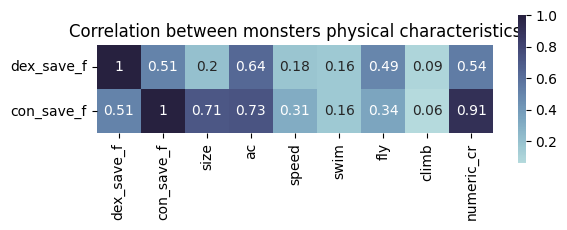

In [5]:
columns_to_analise = ['dex_save_f', 'con_save_f', 
           'size', 'ac', 'speed', 'swim', 'fly', 'climb', 'numeric_cr' ]
dfat = df[columns_to_analise].copy(deep=True)
dfat["size"] = dfat["size"].apply(lambda size : numeric_size[size])
dfat["swim"] = dfat["swim"].apply(lambda x: 1 if x>0 else 0)
dfat["fly"] = dfat["fly"].apply(lambda x: 1 if x>0 else 0)
corrmatat = dfat.corr(numeric_only = True)
hm = sns.heatmap(corrmatat.loc[['dex_save_f', 'con_save_f']].round(2), annot=True, center = 0.5,
                 square = True, cbar_kws={"shrink": 0.4}, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
                )
plt.title("Correlation between monsters physical characteristics")
plt.show()

There are some characteristics on the monsters that might have some influence on the dex saves and con saves. (One that is missing in this plot is the monster type), and we're going to use that to our favor.

The first step is creating a model with the data we have. We have decided to go with a Decission Tree Classifier for reasons later explained. 

We will start by preping the data. For that we need to put the monster types as dummies. <br>
Since we have a slight complexity in the strings defining it, we will manually dummy them.

In [6]:
dfm = df.copy(deep = True)

In [7]:
#correcting known errors
dfm["monster_type"] = dfm["monster_type"].apply( lambda x: 'Fiend (devil)' if x == 'Fiend (devil' else x)
dfm["monster_type"] = dfm["monster_type"].apply( lambda x: 'Humanoid (human)' if x == 'Humanoid (human' else x)

In [8]:
all_m_types = []

for mtype in dfm.monster_type.unique():
    if "(" in mtype:
        splited = mtype.split("(")
        first_type = splited[0].replace(" ","")
        all_m_types.append(first_type.lower())
        second_part = splited[1].replace(")","")
        if second_part != "any race":
            all_m_types.append(second_part.lower())
    else:
        all_m_types.append(mtype.lower())
        
all_m_types = set(all_m_types)

In [9]:
for mtype in all_m_types:
    dfm[mtype] = dfm["monster_type"].apply( lambda x: 1 if mtype in x.lower() else 0)

In [10]:
print("Cleaned types of monsters:\n",sorted(all_m_types))

Cleaned types of monsters:
 ['aberration', 'beast', 'celestial', 'construct', 'demon', 'devil', 'dragon', 'dwarf', 'elemental', 'elf', 'fey', 'fiend', 'giant', 'gnoll', 'gnome', 'goblinoid', 'grimlock', 'human', 'humanoid', 'kobold', 'lizardfolk', 'merfolk', 'monstrosity', 'ooze', 'orc', 'plant', 'sahuagin', 'shapechanger', 'swarm of tiny beasts', 'titan', 'undead']


Now we deal with the numbers

To simplify maths, and to make the model accept our data we will chose a new column to tell us if the dex save is superior, equal or inferior to the con save, giving it 0, 1, or 2 depending on the result

In [11]:
dftr = dfm.copy(deep = True)

In [12]:
dftr["size"] = dftr["size"].apply(lambda size : numeric_size[size]) #change sizes to numbers
#we will simplify to binary these values, since it's hard to know the precise values in combat
dftr["swim"] = dftr["swim"].apply(lambda x: 1 if x>0 else 0) #can swim or not
dftr["fly"]  = dftr["fly"].apply(lambda x: 1 if x>0 else 0)#can fly or not
dftr["climb"]  = dftr["climb"].apply(lambda x: 1 if x>0 else 0)#can climb or not

In [13]:
#We will reuse the function dex_con_finder
dftr["dex_higher_than_con"] = dftr.apply( lambda x: dex_con_finder(x.dex_save_f, x.con_save_f), axis = 1)

In [14]:
dftr[["name", "dex_save_f", "con_save_f", "dex_higher_than_con"]].iloc[35:38]

,name,dex_save_f,con_save_f,dex_higher_than_con
35,Balor,2,12,0
36,Bandit,1,1,1
37,Bandit Captain,5,2,2


Now that we have our data prepared it's time to make our model and train it.<br>
Normally in these cases we take a big slice of the data to train the model, and the rest to test our trained model. This allows to verify the accuracy of the model with random data from a limited pool of data.<br>
I our case we are more interested in using all of our data for three resons.

1. __To make it more precise__. The quantity of monsters being too low and the variability in values being that spread means our data is too thin to have a confident model if we were to slice it. 
2. __So it's overfitted__. Normally when we take a bunch of data the model can be "overfitting" to this data, meaning it predicts very accurately the data it's trained on, but doesn't do well with new data. It happens for example on very small amounts of data, or data with lots of precise noise. Since we are focusing on a small amount of data with high complexity, it will allways be overfitted, even when we slice it up or randomise the tests. By slicing it we would reduce the accuracy, but since we are focusing on the phb monsters, we want to be over fitted over them. This means our model will be _extra_ accurate for our use. For monsters outside the phb... we will have to test it, but that's a story for another time .
3. We actually need it for our fun final project!


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
import matplotlib

we define the columns used to train the model, i.e. the columns the model uses to predict the results, and the result it should predict

In [16]:
X = dftr[list(all_m_types)+[ 'size', 'speed', 'swim', 'fly', 'climb', 'numeric_cr']]
y = dftr[["dex_higher_than_con"]]

In [17]:
dftr[dftr["dex_higher_than_con"].isna()][["dex_higher_than_con"]]

,dex_higher_than_con


We create the model and we feed it our data

In [18]:
clf = DecisionTreeClassifier()
clf = clf.fit(X, y)

Lets show the accuracy results in a nice way


Overall accuracy score:  0.9351851851851852


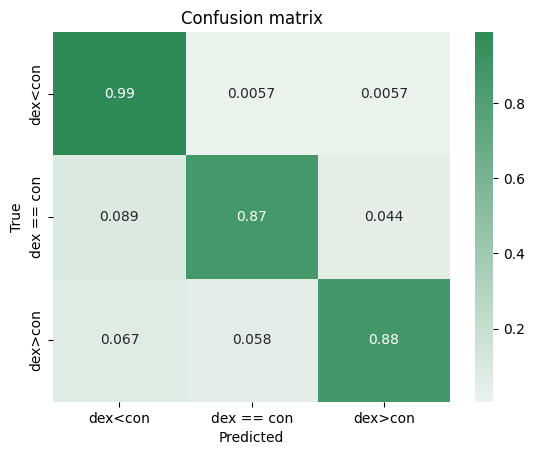

In [19]:
predictions = clf.predict(X)
print("\nOverall accuracy score: ", accuracy_score(y, predictions))

labels = ["dex<con", "dex == con", "dex>con"]
cm = confusion_matrix(y, predictions, normalize = "true")

fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(cm, ax = ax, cmap = sns.light_palette("seagreen", as_cmap=True), annot= True)
plt.title('Confusion matrix')

ax.set_xticklabels(labels);ax.set_yticklabels(labels)
plt.xlabel('Predicted');plt.ylabel('True')
plt.show()

<div class="alert alert-block alert-info">
<font size="2"><b>Pro tip:</b> Confusion matrices are a way to visualise the performance of a predicting algorithm. It's read it like this:<br>(We have normalised our data but here are the numbers)</font>
    
| |d&lt;c|d=c|d&gt;c|
|:-:|:-:|:-:|:-:|
|d&lt;c|173|1|1|
|d=c|4|39|2|
|d&gt;c|7|6|91|
    
<font size="2">From left to right vertically is spread what the model has predicted. For example the model has predicted 173+4+7 = 184 results as being dex&lt;con. Separated vertically we can see of those 184, how many were rightly predicted (173), and how many were predicted as other things than the right thing (4 as d=c and 7 as d>c).
    We can transform the results in a percentage but careful! The percentage are of the total true values, i.e. horizontally added. For example, of the 4+39+2 true d=c values, only 39 have been predicted correctly. The accuracy of the model for each value, correct or no, is then established.</font>
</div> 
    


Ok, the model is finished. We have taken several visual characteristics of the monsters (if it can fly, what kind of monster it is, etc.) and through the unknown magic of "algorithms" we have transformed it into a model that can predict if a monster's dexterity save is lower than its constitution save. Hurray!<br>
Now, of course we're going to have a high accuracy since we're using all of the data to predict... well, all of the data. There are some errors that we will see are logical, but overall we could say this accuracy is very high, and that it is way better than with our rule of thumb specially in lower brackets.



But, wait, this is just a number, and a model we can't even see! What's the usefulness of this Decision Tree Classifier Algorithm? Fancy numbers to just say "yeah this model works I'm the best"? How do you even use it?

Well, one of the magics of a decision tree is that, because it behave like a decision tree (duh), we can actually plot it to have a map of decisions.<br>
This means we can literally plot a protocol to know if a creature has a higher dex save or con save!

### 3.3 Protocol map for dex and con saves <a id="protocol-map"></a>  [<font size="1">▲</font>](#Content-table)

In [20]:
feature_names = X.columns.values
m_types = np.array([x for x in all_m_types], dtype=object)
nb_to_size = { 1: 'Tiny', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'Huge', 6: 'Gargantuan'}

fig, ax = plt.subplots(figsize=(128,80), dpi=100)
_ = tree.plot_tree(clf, 
                   feature_names=list(feature_names),  
                   class_names=['dex << con','dex == con', 'dex >> con'],
                   filled=True, impurity = True, proportion = True
                   )

#lets modify certain aspects to make it more readable
def replace_text(obj):
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        _lines = txt.splitlines()
        result = []
        condition_flag = False
        for i, line in enumerate(_lines):
            f = line.split(" ")[0]
            #condition
            if f in list(feature_names)+["swarm"]:
                condition_flag = True
                #type of monster
                if f in list(m_types)+["swarm"]:
                    if f == "swarm":
                        result.append(f"is not swarm of tiny beasts")
                    else:
                        result.append(f"is not {f}")
                #swim, fly, climb binario
                elif f in ['swim', 'fly', 'climb']:
                    result.append(f"does not {f}")
                #size -> to ext
                elif f == "size":
                    size_nb = float(line.split(" ")[-1])
                    result.append(f"is {nb_to_size[math.floor(size_nb)]} or smaller")
                #speed simple value
                elif f == "speed":
                    result.append(line)           
                #numeric_cr
                elif f == "numeric_cr":
                    result.append(line.replace("numeric_cr", "Cr"))  
            #gini
            elif f == "gini":
                if not condition_flag:
                    n = (1 - round(float(line.split(" ")[-1]), 2))*100
                    l = f"probability of {n}%"
                    result.append(l)  
            #samples
            elif f == "samples":
                pass
            #values
            elif f == "value":
                pass
            #result
            else:
                if not condition_flag:
                    result.append(line.replace("class = ", "")) 
                else:
                    result.append("<- True | False ->") 
        
        obj.set_text("\n".join(result))
    return obj


ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
plt.show()

Well there we go. Hell of a map.

This is the decision tree that can help us know if a monster's dex save is better than their con save. Every node corresponds to a decision point through where we can navigate until we find the answer of our question for that monster. Starting at the begining we just have to follow the nodes and the result will uncover itself.

__With this we can predict with 100% accuracy <font size="1">(93% of the time)</font> what kind of cantrip to use in any situation!__

Now in a serious note, the model is very well fitted over our data, which gives an obvious high score for accuracy, but it's not perfect.<br>
The reason is some values are simply impossible to know for the model.<br>
If we would take some of the elementals we can see why our model has a difficulty for some groups of monsters. (You can follow this example on the map)

In [21]:
int_cols = ['name', 'size', 'monster_type', 'speed', 'swim', 'fly', 'climb', 'dex_save_f', 'con_save_f', 'dex_higher_than_con']
dftr[(dftr.numeric_cr <= 1.5) &\
     (dftr.monstrosity == 0) &\
     (dftr["size"] <= 2) &\
     (dftr.plant == 0) &\
    (dftr.gnome == 0) &\
     (dftr.elemental == 1) &\
     (dftr.numeric_cr > 0.375) &\
     (dftr.fly == 1) ]\
    [int_cols]

,name,size,monster_type,speed,swim,fly,climb,dex_save_f,con_save_f,dex_higher_than_con
92,Dust Mephit,2,Elemental,30,0,1,0,2,0,2
172,Ice Mephit,2,Elemental,30,0,1,0,1,0,2
189,Magma Mephit,2,Elemental,30,0,1,0,1,1,1


As we see for the same characteristic there's a bunch of monsters with different results. Our model is limited by the scarceness of data differenciating between these different monsters.